In [1]:
import matplotlib.pyplot as plt
import cv2
from glob import glob
import numpy as np
from keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, Input, concatenate
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
mask_path = r"D:\Data Scientist\Projects\road segmentation\dataset\train\masks"
img_path = r"D:\Data Scientist\Projects\road segmentation\dataset\train\images"

In [3]:
images_datagen = ImageDataGenerator(
    rescale=1./255,
    channel_shift_range=20,  # کاهش مقدار تغییر رنگ کانال‌ها
    brightness_range=[0.8, 1.2]  # کاهش بازه تغییر روشنایی
)

images_generator = images_datagen.flow_from_directory(
        img_path,
        target_size=(256, 256),
        batch_size=8,
        class_mode=None,
        shuffle=False)


masks_datagen = ImageDataGenerator(rescale=1./255)

masks_generator = masks_datagen.flow_from_directory(
        mask_path,
        target_size=(256, 256),
        batch_size=8,
        class_mode=None,
        shuffle=False)


Found 5602 images belonging to 1 classes.
Found 5602 images belonging to 1 classes.


In [4]:
mask_path = r"D:\Data Scientist\Projects\road segmentation\dataset\valid\masks"
img_path = r"D:\Data Scientist\Projects\road segmentation\dataset\valid\images"

In [5]:
images_val_datagen = ImageDataGenerator(rescale=1./255)

images_val_generator = images_val_datagen.flow_from_directory(
        img_path,
        target_size=(256, 256),
        batch_size=8,
        class_mode=None,
        shuffle=False)


masks_val_datagen = ImageDataGenerator(rescale=1./255)

masks_val_generator = masks_val_datagen.flow_from_directory(
        mask_path,
        target_size=(256, 256),
        batch_size=8,
        class_mode=None,
        shuffle=False)


Found 624 images belonging to 1 classes.
Found 624 images belonging to 1 classes.


In [6]:
def combined_generator(img_gen, msk_gen):
    while True:
        X = next(img_gen)
        y = next(msk_gen)
        yield X, y

In [7]:
val_generator = combined_generator(images_val_generator, masks_val_generator)

In [8]:
train_generator = combined_generator(images_generator, masks_generator)

In [9]:
batch_image = images_generator.next()

In [10]:
batch_mask = masks_generator.next()

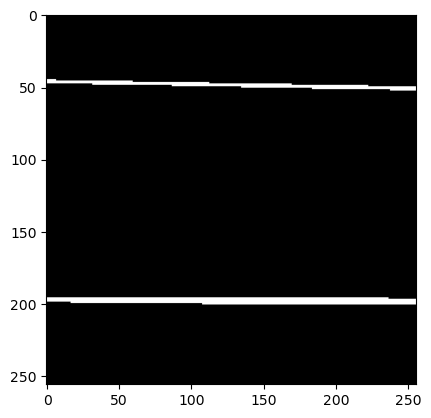

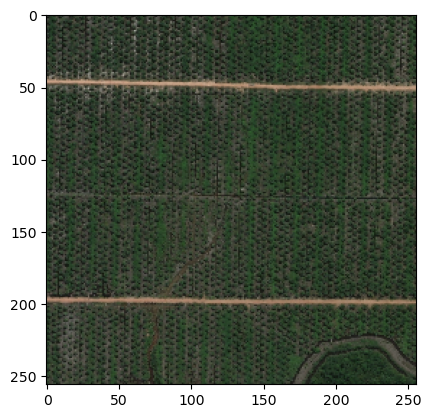

In [11]:
plt.imshow(batch_mask[1], cmap='gray')
plt.show()
plt.imshow(batch_image[1])
plt.show()

In [12]:
input = Input(shape=(256, 256, 3))

conv1_encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(input)
conv1_encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1_encoder)
pool1_encoder = MaxPool2D(pool_size=(2, 2))(conv1_encoder)

conv2_encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1_encoder)
conv2_encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2_encoder)
pool2_encoder = MaxPool2D(pool_size=(2, 2))(conv2_encoder)

conv3_encoder = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2_encoder)
conv3_encoder = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3_encoder)
pool3_encoder = MaxPool2D(pool_size=(2, 2))(conv3_encoder)

conv4_encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3_encoder)
conv4_encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4_encoder)
pool4_encoder = MaxPool2D(pool_size=(2, 2))(conv4_encoder)

conv5_encoder = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4_encoder)
conv5_encoder = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5_encoder)

upconv1_decoder = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5_encoder)
concat1 = concatenate([conv4_encoder, upconv1_decoder])
conv1_decoder = Conv2D(256, (3, 3), activation='relu', padding='same')(concat1)
conv1_decoder = Conv2D(256, (3, 3), activation='relu', padding='same')(conv1_decoder)

upconv2_decoder = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv1_decoder)
concat2 = concatenate([conv3_encoder, upconv2_decoder])
conv2_decoder = Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)
conv2_decoder = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2_decoder)

upconv3_decoder = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv2_decoder)
concat3 = concatenate([conv2_encoder, upconv3_decoder])
conv3_decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(concat3)
conv3_decoder = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3_decoder)

upconv4_decoder = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv3_decoder)
concat4 = concatenate([conv1_encoder, upconv4_decoder])
conv4_decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(concat4)
conv4_decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4_decoder)

output = Conv2D(1, (1, 1), activation='sigmoid', name='output_color')(conv4_decoder)

model = Model(inputs=[input], outputs=[output])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [14]:
opt = tf.keras.optimizers.Adam(0.001)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=opt, loss=loss)

In [15]:
len(masks_generator)

701

In [16]:
len(masks_val_generator)

78

In [95]:
history = model.fit(
    train_generator,  # Use the combined generator that yields both X and y
    steps_per_epoch=701,
    validation_data=val_generator,
    validation_steps=78,
    epochs=4,
    verbose=2
)

Epoch 1/4
701/701 - 941s - loss: 0.0653 - val_loss: 0.0726 - 941s/epoch - 1s/step
Epoch 2/4
701/701 - 952s - loss: 0.0651 - val_loss: 0.0729 - 952s/epoch - 1s/step
Epoch 3/4
701/701 - 937s - loss: 0.0639 - val_loss: 0.0712 - 937s/epoch - 1s/step
Epoch 4/4
701/701 - 940s - loss: 0.0631 - val_loss: 0.0700 - 940s/epoch - 1s/step


In [112]:
image_path = glob(r"D:\Data Scientist\Projects\road segmentation\dataset\test\*.jpg")

image_path = image_path[:10]

image = []

for path in image_path:
    img = cv2.resize(cv2.imread(path), (256,256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image.append(img) 

image = np.array(image) / 255.0

In [ ]:
pred_img = model.predict(image)

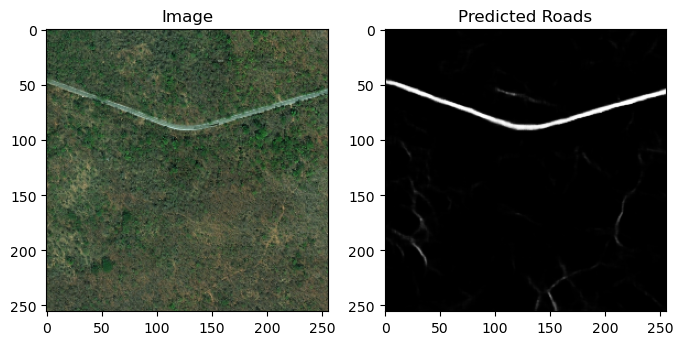

In [107]:
plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.imshow(image[4])
plt.title('Image')

plt.subplot(1,2,2)
plt.imshow(pred_img[4], cmap='gray')
plt.title('Predicted Roads')

plt.show()

In [99]:
mask_path = glob(r"D:\Data Scientist\Projects\road segmentation\dataset\valid\masks\masks\*.png")
img_path = glob(r"D:\Data Scientist\Projects\road segmentation\dataset\valid\images\images\*.jpg")

mask_path = mask_path[:10]
img_path = img_path[:10]

img = []
mask = []

for path in img_path:
    img_ = cv2.resize(cv2.imread(path), (256,256))
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img.append(img_)
    
for path in mask_path:
    mask_ = cv2.resize(cv2.imread(path), (256,256))
    mask_ = cv2.cvtColor(mask_, cv2.COLOR_BGR2RGB)
    mask.append(mask_)

    
    

img = np.array(img) / 255.0
mask = np.array(mask) / 255.0

In [100]:
pred_img = model.predict(img)

1/1 [==============================] - 0s 56ms/step


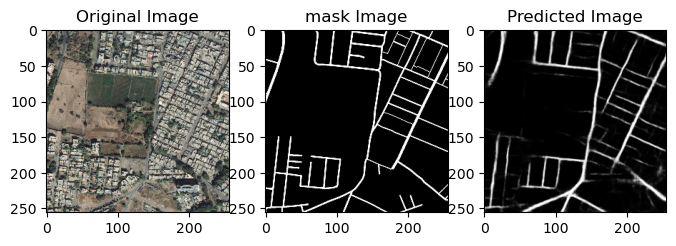

In [101]:
plt.figure(figsize=(8,4))

plt.subplot(1,3,1)
plt.imshow(img[8])
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(mask[8])
plt.title('mask Image')

plt.subplot(1,3,3)
plt.imshow(pred_img[8], cmap='gray')
plt.title('Predicted Image')

plt.show()

In [102]:
model.save('my_model.h5')

In [103]:
model.save_weights('my_model_weights.h5')